# [Table of Contents](#toc0_)
* [1. Aggregate inflation in Denmark](#sec1)
  * [1.1 Basics](#sec1-1)
  * [1.2 Instantaneous inflation](#sec1-2)
  * [1.3 Core inflation](#sec1-3)
  * [1.4 Disaggregated inflation in Denmark](#sec1-4)
* [2. International Comparison](#sec2)
  * [2.1 CPI vs HICP](#sec2-1)
  * [2.2 Across countries](#sec2-2)


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from dstapi import DstApi
from fredapi import Fred

plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 12})

## 1. <a id="sec1"></a>[Aggregate inflation in Denmark](#toc0_)

### 1.1 <a id="sec1-1"></a>[Basics](#toc0_)

Downloading data: 
1. Link til at forstå dst API: https://alemartinello.com/posts/Using%20DSTs%20API%20with%20python.html
2. tablesummary method is applied to examine data 
3. define base params method is applied to get base dictionary of parameters with default values
4. get data method is applied to get the data according to the params dictonary 

In [693]:
PRIS113_api = DstApi('PRIS113')
PRIS113_api.tablesummary(language='en')


Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [694]:
params = PRIS113_api._define_base_params(language='en')
display(params)

{'table': 'pris113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TYPE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [695]:
PRIS113 = PRIS113_api.get_data(params=params)

Rename, replace and so on

In [696]:
PRIS113.head()

,TYPE,TID,INDHOLD
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6


In [ ]:
PRIS113=PRIS113.drop(columns=['TYPE'])

columns_dict = {}
columns_dict['TID'] = 'QY'
columns_dict['INDHOLD'] = 'CPI'

PRIS113=PRIS113.rename(columns=columns_dict)

PRIS113['DATE'] = pd.to_datetime(PRIS113['QY'], format='%YM%m')
PRIS113['year']=PRIS113['DATE'].dt.year
PRIS113=PRIS113.sort_values(by='DATE')
PRIS113=PRIS113.set_index('DATE')
PRIS113.CPI = PRIS113.CPI.astype('float')

Calculations
1. Calculate annual average
2. Reindex annual CPI to 2020 - 2020=100
3. Calculate inflation: month-to-month and 12-month inflation rate

The annual average is calculated using the resample by year method. 

Using loc a new coloumn with the index of 2020 is created. CPI is reindex to 2020 by calculating:

$CPI_t^{2020=100}=\frac{CPI}{Index2020}$


In [ ]:
annual = PRIS113['CPI'].resample('YS').mean().rename('CPI_annual').reset_index()
annual['Index2020'] = annual.loc[annual['DATE'].dt.year == 2020, 'CPI_annual'].values[0]
annual['CPI_annual_2020_100'] = annual['CPI_annual'] / annual['Index2020'] * 100
annual['year'] = annual['DATE'].dt.year 

In [699]:
annual.tail(6)

,DATE,CPI_annual,Index2020,CPI_annual_2020_100,year
40,2020-01-01,103.433333,103.433333,100.000000,2020
41,2021-01-01,105.350000,103.433333,101.853045,2021
42,2022-01-01,113.458333,103.433333,109.692233,2022
43,2023-01-01,117.208333,103.433333,113.317757,2023
44,2024-01-01,118.816667,103.433333,114.872704,2024
45,2025-01-01,120.866667,103.433333,116.854657,2025


The inflation and 12-month inflation is calculated using the pct_change method.
The 12-month inflation is evaluated at periods=12

In [ ]:
PRIS113['inflation']=PRIS113['CPI'].pct_change()*100
PRIS113['inflation_12']=PRIS113['CPI'].pct_change(periods=12)*100
PRIS113.tail()

,QY,CPI_index,year,inflation,inflation_12
DATE,,,,,
2025-05-01,2025M05,120.4,2025,0.083126,1.603376
2025-06-01,2025M06,120.7,2025,0.249169,1.856540
2025-07-01,2025M07,122.5,2025,1.491301,2.253756
2025-08-01,2025M08,121.7,2025,-0.653061,2.011735
2025-09-01,2025M09,121.6,2025,-0.082169,2.270816


#### 1.1.1: Consumer price index, 2020=100

The reindexed consumper price index is plotted. 

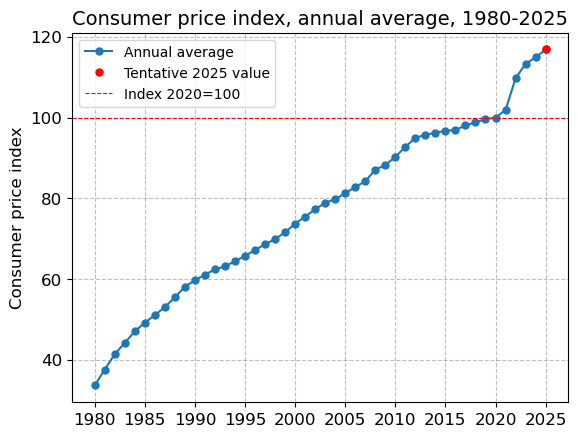

In [701]:
annual = annual.sort_values('year').reset_index(drop=True)
x_last = annual['year'].iloc[-1]
y_last = annual['CPI_annual_2020_100'].iloc[-1]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(annual['year'], annual['CPI_annual_2020_100'],marker='o', markersize=5, label='Annual average')
ax.plot(x_last, y_last, marker='o', ms=5, mfc='red', mec='red', ls='None', label='Tentative 2025 value')
ax.set_xticks(np.arange(1980, 2026, 5))
ax.set_ylabel('Consumer price index', size=12)
ax.axhline(y=100, color='red', linestyle='--', linewidth=0.8, label="Index 2020=100")
ax.set_title('Consumer price index, annual average, 1980-2025', size=14)


ax.legend(ncol=1,loc='upper left',prop={'size': 10})  

Mangler: When did the post-pandemic inflation surge end in Denmark?

#### 1.1.2: Month-to-month inflation rate

The month to month inflation rate is plotted. 

Text(0, 0.5, 'pct. change')

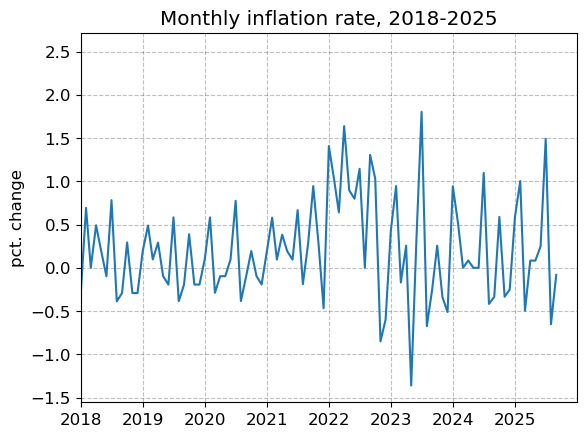

In [702]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x=PRIS113.index


ax.plot(x, PRIS113['inflation'], label='Inflation rate')

ax.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('Monthly inflation rate, 2018-2025')
ax.set_ylabel('pct. change')


Mangler: When did the post-pandemic inflation surge end in Denmark?

Monthly quite volatile - wide yearly dispersion

#### 1.1.3 The 12-month inflation rate

The 12-month inflation rate is plotted

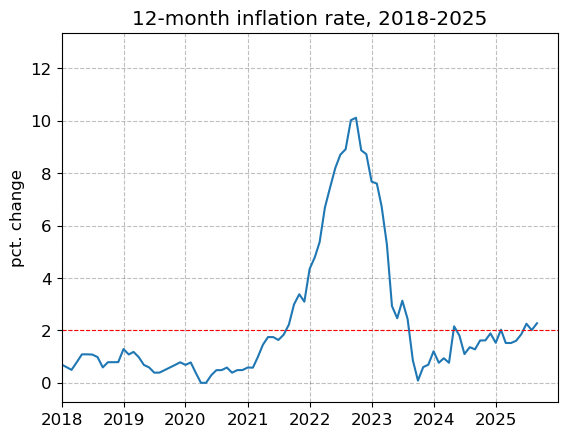

In [703]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x=PRIS113.index

ax.plot(x, PRIS113['inflation_12'], label='Inflation rate')
ax.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('12-month inflation rate, 2018-2025')
ax.set_ylabel('pct. change')

ax.axhline(y=2.0, color='red', linestyle='--', linewidth=0.8, label="Index 2020=100")

Mangler: When did the post-pandemic inflation surge end in Denmark?

### 1.2 <a id="sec1-2"></a>[Instantaneous inflation](#toc0_)

#### 1.2.1: Plotting the weighting function $\kappa$

$\kappa$ is defined as a function with $\alpha$ as an argument. 
The function returns a vector of weights. 

In [704]:
def K_func(alpha, T=12):
    j = np.arange(T)                       
    denom = np.sum((T - j)**alpha)
    w = T * (T - j)**alpha / denom  
    return w


$\kappa(k,\alpha)$ is plotted for $\alpha \in {0,1,2,3}$

Text(0, 0.5, '$\\kappa$')

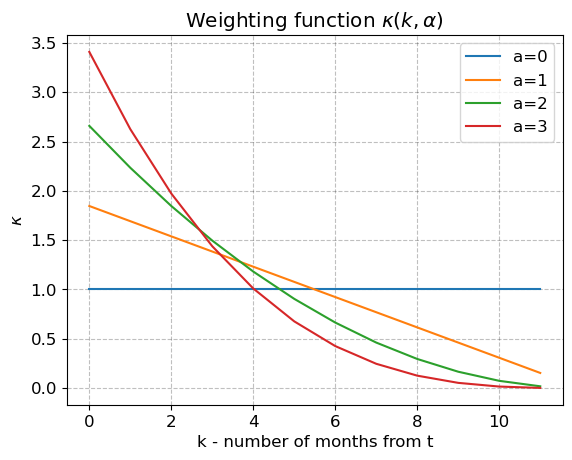

In [705]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

k_vec = np.arange(0,12)

for a in [0,1,2,3]:
    K=K_func(a)
    ax.plot(k_vec, K, label=f'a={a}')

ax.legend()  
ax.set_title(r'Weighting function $\kappa(k,\alpha)$')
ax.set_xlabel('k - number of months from t')
ax.set_ylabel(r'$\kappa$')    

$k$ is given by $k\in{0,1,2,...,11}$ and defines the number of periods from $t$. Recent months is given by a low $k$ value. The plot illustrates the weighting scheme: for higher $\alpha$ more weight is placed on inflation in recent months. 
1. $\alpha=0$ : all 12 months get equal weight and the instantaneous inflation rate equals the 12-month inflation. (in the product all elements cancel except for $t$ and $t-12$). 
2. $\alpha=1$:  weights decline linearly with $k$. 
3. $\alpha>1$: convex relationship - weights fall faster on older months — increasing emphasis on recent observations.
4. $\alpha \rightarrow \infty$: all weight goes to the most recent month. The higher $\alpha$, the more “now-focused” the measure becomes.

#### 1.2.2: Computing the instantaneous inflation rate

The instantaneous inflation is defined as a function of $\alpha$ containing: 
1. the inflation rate calculated using the pct_change method 
2. the weighting using the function K_func defined in the previous section. 
Here the order of the vector is reversed to match the order of the rolling.apply method 
3. the instantaneous inflation is computed using the rolling.apply method - for each $t$ rolling over the previous 11 periods.  
4. calculated for $\alpha\in {0,1,2,3}$

In [ ]:
def instantaneous_inflation(alpha, T=12):
    pi = PRIS113['CPI'].pct_change(1)
    w = K_func(alpha)[::-1]              
    func = lambda x: np.prod((1.0 + x)**w) - 1.0
    return pi.rolling(T).apply(func)*100


for alpha in [0, 1, 2, 3]:
    PRIS113[f'instantaneous_inflation_{alpha}'] = instantaneous_inflation(alpha)


#### 1.2.3: Plotting the instantaneous inflation rate

The instantaneous inflation is plotted for $\alpha\in {0,1,2,3}$ from 2019 onward. 

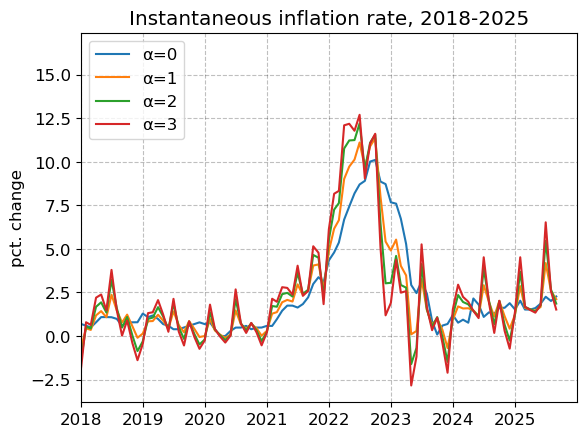

In [707]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for alpha in [0, 1, 2, 3]:
    ax.plot(PRIS113.index, PRIS113[f'instantaneous_inflation_{alpha}'], label=f'α={alpha}')

ax.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('Instantaneous inflation rate, 2018-2025')
ax.set_ylabel('pct. change')
ax.legend(loc='upper left')


MANGLER: Can this be used to say something new about when the post-pandemic inflation
surge ended in Denmark compared to your analysis above?


The plot for $\alpha=0$ equals the 12-month inflation rate. The higher-$\alpha$ series reacts earlier than the 12-month inflation rate because it downweights old base effects. In the plot, the curves for $\alpha=2$ and $\alpha=3$ turn down and stay low a few months before the 12-month inflation rate around 2022/2023. So the “instantaneous” measures sharpen the dating of when the post-pandemic surge effectively ended; they don’t change the story, they just reveal it sooner. 

### 1.3 <a id="sec1-3"></a>[Core inflation](#toc0_)


Data is downloadet

In [708]:
PRIS111 = DstApi('PRIS111')
PRIS111.tablesummary(language='en')
params = PRIS111._define_base_params(language='en')
display(params)

PRIS111 = DstApi('PRIS111').get_data(params=params)

I = PRIS111['INDHOLD'] == '..'
PRIS111.loc[I,'INDHOLD'] = 'nan'
PRIS111['INDHOLD'] = PRIS111.INDHOLD.astype(float)
PRIS111.head()

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['*']},
  {'code': 'ENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

,VAREGR,ENHED,TID,INDHOLD
0,04.4.4.2 Security services,Index,2001M01,NaN
1,04.4.4.2 Security services,Percentage change compared to previous month (...,2001M01,NaN
2,04.4.4.2 Security services,Percentage change compared to same month the y...,2001M01,NaN
3,04.4.4.9 Other services related to dwelling,Index,2001M01,NaN
4,04.4.4.9 Other services related to dwelling,Percentage change compared to previous month (...,2001M01,NaN


Dictonary is prepared: 
1. From the variable dictonary we are preparing the series of interest 
2. From the unit dictonary we are preparing the unit of interest: 12-month inflation rate

In [709]:
var_dict = {} # var is for variable
var_dict['00 Consumer price index, total'] = 'CPI_TOT'
var_dict['14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)'] = 'core_inflation'
var_dict['15.1 Overall Consumer Price Index excl. energy'] = 'CPI_ex_energy'

columns_dict = {}
columns_dict['VAREGR'] = 'series'
columns_dict['ENHED'] = 'unit'
columns_dict['TID'] = 'YM'
columns_dict['INDHOLD'] = 'value'

unit_dict = {}
unit_dict['Percentage change compared to same month the year before (per cent)'] = '12_month_index'

In [710]:
PRIS111=PRIS111.rename(columns=columns_dict)

for key,value in unit_dict.items():
   PRIS111.unit = PRIS111.unit.replace(key,value)


for key,value in var_dict.items():
    PRIS111.series = PRIS111.series.replace(key,value)

I=PRIS111.unit.isin(['12_month_index'])
PRIS111=PRIS111[I]

I=PRIS111.series.isin(['CPI_TOT','core_inflation','CPI_ex_energy'])
PRIS111=PRIS111[I]

PRIS111['DATE'] = pd.to_datetime(PRIS111['YM'], format='%YM%m')
PRIS111['year']=PRIS111['DATE'].dt.year
PRIS111=PRIS111.sort_values(by='DATE')
PRIS111=PRIS111.set_index('DATE')

Figure for the three series is plottet for the time period of interest

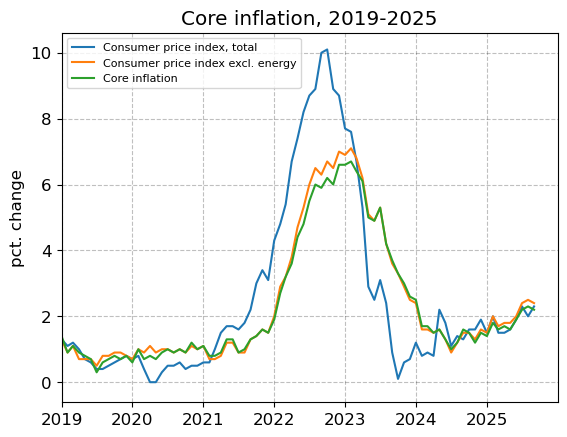

In [711]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x=PRIS111.index

for val, sub in PRIS111.groupby('series'):
    I=PRIS111['series']==val
    if val=='core_inflation':
        label='Core inflation'
    if val=='CPI_TOT':
        label='Consumer price index, total'
    if val=='CPI_ex_energy':
        label='Consumer price index excl. energy'
    ax.plot(x[I], sub['value'], label=label)

ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('Core inflation, 2019-2025')
ax.set_ylabel('pct. change')
ax.legend(loc='upper left',prop={'size': 8})


MANGLER: What does this tell us about the most likely drivers of the post-pandemic inflation
surge in Denmark?

### 1.4 <a id="sec1-4"></a>[Disaggregated inflation in Denmark](#toc0_)

In [712]:
PRIS111 = DstApi('PRIS111')
PRIS111.tablesummary(language='en')
params = PRIS111._define_base_params(language='en')
display(params)


Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['*']},
  {'code': 'ENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

#### 14.1. create list

In [713]:
levels=PRIS111.variable_levels('VAREGR',language='en')
for row in levels.itertuples(): print(row.id,row.text)

000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice
011120 01.1.1.2 Flours and other cereals
011130 01.1.1.3 Bread
011140 01.1.1.4 Other bakery products
011150 01.1.1.5 Pizza and quiche
011160 01.1.1.6 Pasta products and couscous
011170 01.1.1.7 Breakfast cereals
011180 01.1.1.8 Other cereal products
011200 01.1.2 Meat
011210 01.1.2.1 Beef and veal
011220 01.1.2.2 Pork
011230 01.1.2.3 Lamb and goat
011240 01.1.2.4 Poultry
011260 01.1.2.6 Edible offal
011270 01.1.2.7 Dried, salted or smoked meat
011280 01.1.2.8 Other meat preparations
011300 01.1.3 Fish and seafood
011310 01.1.3.1 Fresh or chilled fish
011320 01.1.3.2 Frozen fish
011340 01.1.3.4 Frozen seafood
011350 01.1.3.5 Dried, smoked or salted fish and seafood
011360 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 01.1.4 Milk, cheese and eggs
011410 01.1.4.1 Milk, whole, fresh
011420 01.1.4.2 Milk, lo

We define 4-digit product categories as codes with exactly three dots (e.g., 01.1.1.3).
The list is obtained by filtering strings that start with such a code (two digits followed by three dot-separated single digits), ensuring we keep only level-4 items (regex: ^\d{2}(?:\.\d){3}\s).

In [714]:
I = levels['text'].str.contains(r'^\d{2}(?:\.\d){3}\s', regex=True, na=False)
four = levels.loc[I].copy()
four.head(20)

,id,text
4,011110,01.1.1.1 Rice
5,011120,01.1.1.2 Flours and other cereals
6,011130,01.1.1.3 Bread
7,011140,01.1.1.4 Other bakery products
8,011150,01.1.1.5 Pizza and quiche
9,011160,01.1.1.6 Pasta products and couscous
10,011170,01.1.1.7 Breakfast cereals
11,011180,01.1.1.8 Other cereal products
13,011210,01.1.2.1 Beef and veal
14,011220,01.1.2.2 Pork


We split the text column into two separate columns: code (the dotted 4-level code) and name (the item label).

In [715]:
four[['code','name']] = four['text'].str.extract(r'^(\d{2}(?:\.\d){3})\s+(.*)')

In [716]:
four.head(10)

,id,text,code,name
4,011110,01.1.1.1 Rice,01.1.1.1,Rice
5,011120,01.1.1.2 Flours and other cereals,01.1.1.2,Flours and other cereals
6,011130,01.1.1.3 Bread,01.1.1.3,Bread
7,011140,01.1.1.4 Other bakery products,01.1.1.4,Other bakery products
8,011150,01.1.1.5 Pizza and quiche,01.1.1.5,Pizza and quiche
9,011160,01.1.1.6 Pasta products and couscous,01.1.1.6,Pasta products and couscous
10,011170,01.1.1.7 Breakfast cereals,01.1.1.7,Breakfast cereals
11,011180,01.1.1.8 Other cereal products,01.1.1.8,Other cereal products
13,011210,01.1.2.1 Beef and veal,01.1.2.1,Beef and veal
14,011220,01.1.2.2 Pork,01.1.2.2,Pork


A category map dataframe is created - only retaining the name and text column.


Slet: Til csv blot for man lige selv kan tjekke og se.


In [717]:
cat_map = four[['name', 'text']].rename(columns={'text':'series'})
cat_map.to_csv('cat_map.csv', index=True)

#### 14.2. 12-month inflation rate, percentiles and plot

Dictonary is prepared, data is downloadet and cleaned

In [718]:
PRIS111.variable_levels('ENHED',language='en')

,id,text
0,100,Index
1,200,Percentage change compared to previous month (...
2,300,Percentage change compared to same month the y...


In [719]:
columns_dict = {}
columns_dict['VAREGR'] = 'series'
columns_dict['ENHED'] = 'unit'
columns_dict['TID'] = 'YM'
columns_dict['INDHOLD'] = 'value'

unit_dict = {}
unit_dict['Index'] = 'CPI'

In [720]:
PRIS111 = PRIS111.get_data(params=params)

In [721]:
I = PRIS111['INDHOLD'] == '..'
PRIS111.loc[I,'INDHOLD'] = 'nan'
PRIS111['INDHOLD'] = PRIS111.INDHOLD.astype(float)

In [ ]:
PRIS111=PRIS111.rename(columns=columns_dict)

for key,value in unit_dict.items():
   PRIS111.unit = PRIS111.unit.replace(key,value)


I=PRIS111.unit.isin(['CPI'])
PRIS111=PRIS111[I]
PRIS111=PRIS111.drop(columns=['unit'])
PRIS111=PRIS111.rename(columns={'value':'CPI'})

PRIS111['DATE'] = pd.to_datetime(PRIS111['YM'], format='%YM%m')
PRIS111=PRIS111.drop(columns=['YM'])
PRIS111=PRIS111.sort_values(by='DATE')
PRIS111=PRIS111.set_index('DATE')

The category map and PRIS111 is merged by inner join. 

We are only keeping the rows of PRIS111 for the 4-figit product categories. 

In [723]:
merged = PRIS111.join(cat_map.set_index('series'), on='series', how='inner').reset_index()

The 12-month inflation rate is computed for each 4-digit product category using the .groupby method

In [ ]:
merged['inflation_12']=merged.groupby('series')['CPI'].pct_change(periods=12, fill_method=None)*100

The 25th, 50th and 75th percentile is computed for each month in the data using .agg.

In [725]:
monthly_pcts = (merged.dropna(subset=['inflation_12']) 
                  .groupby('DATE')['inflation_12']
                  .agg(q25=lambda s: s.quantile(0.25),
                       q50='median',
                       q75=lambda s: s.quantile(0.75))
                  .reset_index())

In [726]:
monthly_pcts.tail()

,DATE,q25,q50,q75
184,2025-05-01,-1.222684,1.259446,3.589305
185,2025-06-01,-1.555470,1.150442,3.624091
186,2025-07-01,-0.098819,1.903974,4.087990
187,2025-08-01,-0.492211,1.851852,3.865200
188,2025-09-01,-1.154418,1.433121,4.061775


Plotting the monthly percentiles for the time period 2010-2025

Text(0, 0.5, 'pct. change')

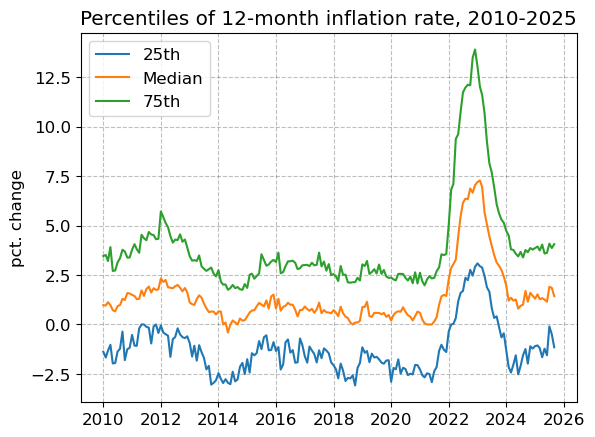

In [727]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(monthly_pcts['DATE'], monthly_pcts['q25'], label='25th')
ax.plot(monthly_pcts['DATE'], monthly_pcts['q50'], label='Median')
ax.plot(monthly_pcts['DATE'], monthly_pcts['q75'], label='75th')
ax.legend()
ax.set_title('Percentiles of 12-month inflation rate, 2010-2025')
ax.set_ylabel('pct. change')


MANGLER: FORTOLK

#### 1.4.3 Histogram of the percent change from aug 2020 to aug 2025

A new dataframe is created by filtering on date. The filter condition is: date in August 2020 or date in August 2025. 

In [728]:
merged=merged.set_index('DATE')

In [729]:
I = merged.index.isin([pd.Timestamp('2020-08-01'), pd.Timestamp('2025-08-01')])
merged_sel = merged.loc[I].reset_index()


(SLET to csv: blot for at kunne tjekke selv)

In [730]:
merged_sel.to_csv('ny.csv', index=False)

The percent change in prices from August 2020 to August 2025 is calculated using the pct_change method

In [ ]:
merged_sel['pct_change'] = merged_sel.groupby('series')['CPI'].pct_change(periods=1, fill_method=None)*100

(SLET to csv: blot for at kunne tjekke selv)

In [732]:
merged_sel.to_csv('ny.csv', index=False)

Histogram of percent changes in prices is plottet

Text(0, 0.5, 'Frequency')

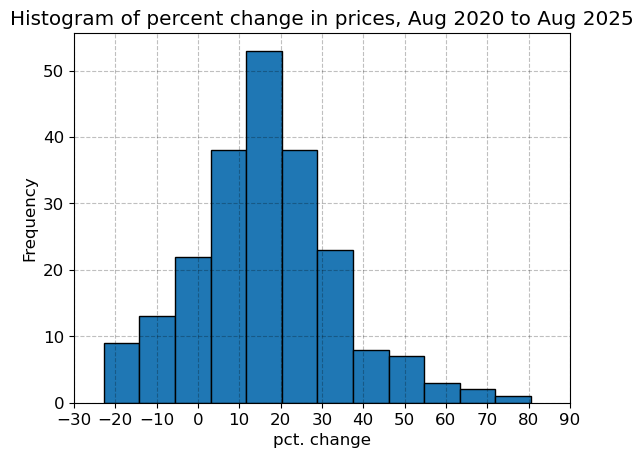

In [733]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(merged_sel['pct_change'].dropna(), bins=12, edgecolor='black')
ax.set_xticks(np.arange(-30, 91, 10))
ax.set_title('Histogram of percent change in prices, Aug 2020 to Aug 2025')
ax.set_xlabel('pct. change')
ax.set_ylabel('Frequency')

MANGLER: Describe what you see.

#### 1.4.4. Ranking of categories

Based on the August 2020 to 2025 percent change top 10 and bottom 10 product categories is calculated. 

1. Filtering by date
2. Only keeping observations where pct_change has values 
3. Ranking min and max using rank method 

In [734]:
latest = pd.Timestamp('2025-08-01')
cross = (merged_sel.loc[merged_sel['DATE'] == latest, ['series','name','pct_change']]
               .dropna(subset=['pct_change'])
               .copy())

cross['rank_max'] = cross['pct_change'].rank(ascending=False, method='min').astype(int)  # 1 = største
cross['rank_min']  = cross['pct_change'].rank(ascending=True,  method='min').astype(int)  # 1 = mindste

cross = cross.sort_values(by='pct_change', ascending=False).reset_index(drop=True)

cross.head()

,series,name,pct_change,rank_max,rank_min
0,08.1.0.1 Letter handling services,Letter handling services,80.585735,1,217
1,01.2.1.1 Coffee,Coffee,69.712526,2,216
2,02.2.0.3 Other tobacco products,Other tobacco products,65.201465,3,215
3,07.3.3.1 Domestic flights,Domestic flights,62.758621,4,214
4,01.1.5.1 Butter,Butter,57.085020,5,213


The top and bottom 10 product categories is illustrated in a table
1. Version 1: Latex 
2. Version 2: Printing in text 
3. Version 3: exporting to csv

In [736]:
name_top=top10['name'].values.tolist()
name_bot=bot10['name'].values.tolist()
pct_top=top10['pct_change'].values.tolist()
pct_bot=bot10['pct_change'].values.tolist()
rank_top=top10['rank_max'].values.tolist()
rank_bot=bot10['rank_min'].values.tolist()

top_tbl = pd.DataFrame({"rank": rank_top, "name": name_top, "pct_change": pct_top}).sort_values("rank")
bot_tbl = pd.DataFrame({"rank": rank_bot, "name": name_bot, "pct_change": pct_bot}).sort_values("rank")


Latex

In [737]:
print(top_tbl.to_latex(index=False,
                       float_format='{:.3f}'.format,
                       column_format='l p{7cm} r',
                       caption='Top 10 categories by pct change',
                       label='tab:top10'))


\begin{table}
\caption{Top 10 categories by pct change}
\label{tab:top10}
\begin{tabular}{l p{7cm} r}
\toprule
rank & name & pct_change \\
\midrule
1 & Letter handling services & 80.586 \\
2 & Coffee & 69.713 \\
3 & Other tobacco products & 65.201 \\
4 & Domestic flights & 62.759 \\
5 & Butter & 57.085 \\
6 & Cocoa and powdered chocolate & 56.907 \\
7 & Other edible oils & 52.802 \\
8 & Beef and veal & 52.736 \\
9 & Chocolate & 50.844 \\
10 & Natural gas and town gas & 49.565 \\
\bottomrule
\end{tabular}
\end{table}



In [738]:
print(bot_tbl.to_latex(index=False,
                       float_format='{:.3f}'.format,
                       column_format='l p{7cm} r',
                       caption='Top 10 categories by pct change',
                       label='tab:top10'))

\begin{table}
\caption{Top 10 categories by pct change}
\label{tab:top10}
\begin{tabular}{l p{7cm} r}
\toprule
rank & name & pct_change \\
\midrule
1 & Irons & -22.765 \\
2 & Personal computers & -21.140 \\
3 & Other small electric household appliances & -18.934 \\
4 & Fiction books & -18.158 \\
5 & Toasters and grills & -17.724 \\
6 & Food processing appliances & -17.635 \\
7 & Non-electric kitchen utensils and articles & -16.009 \\
8 & Cutlery, flatware and silverware & -14.901 \\
9 & Other furniture and furnishings & -14.170 \\
10 & Glassware, crystal-ware, ceramic ware and chinaware & -11.818 \\
\bottomrule
\end{tabular}
\end{table}



Printing

In [739]:
print("Top 10 categories")
print(top_tbl.to_string(index=False, formatters={"pct_change": "{:.2f}".format}))
print("\nBottom 10 categories")
print(bot_tbl.to_string(index=False, formatters={"pct_change": "{:.2f}".format}))


Top 10 categories
 rank                         name pct_change
    1     Letter handling services      80.59
    2                       Coffee      69.71
    3       Other tobacco products      65.20
    4             Domestic flights      62.76
    5                       Butter      57.09
    6 Cocoa and powdered chocolate      56.91
    7            Other edible oils      52.80
    8                Beef and veal      52.74
    9                    Chocolate      50.84
   10     Natural gas and town gas      49.57

Bottom 10 categories
 rank                                                name pct_change
    1                                               Irons     -22.77
    2                                  Personal computers     -21.14
    3           Other small electric household appliances     -18.93
    4                                       Fiction books     -18.16
    5                                 Toasters and grills     -17.72
    6                          Food proc

To CSV

In [740]:
top_tbl.to_csv('top_10.csv', index=False)
bot_tbl.to_csv('bot_10.csv', index=False)

## 2. <a id="sec2"></a>[International Comparison](#toc0_)

### 2.1 <a id="sec2-1"></a>[CPI vs HICP](#toc0_)

Downloading Harmonized Index for Consumer Prices (HICP) from FRED:

In [681]:
with open('/Users/thereseschlanderandersen/Documents/Programmering/1. Thereses mappe//fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

In [682]:
series = {
     "CP0000DKM086NEST":"HICP",
}

In [683]:
for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,CP0000DKM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


In [684]:
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded CP0000DKM086NEST from FRED and saved it as HICP           


In [688]:
df = pd.DataFrame(data)
df.head()

,HICP
1996-01-01,70.4
1996-02-01,70.8
1996-03-01,71.3
1996-04-01,71.5
1996-05-01,71.7


In [ ]:
df = df.rename_axis('DATE')
df.head()

Reusing the previous downloadet CPI series from PRIS113 - only retaining the CPI and merging with the FRED data.

In [ ]:
PRIS113_sammenligning=PRIS113['CPI'].copy().reset_index()
PRIS113_sammenligning=PRIS113_sammenligning.set_index('DATE')

In [ ]:
merge_inflation = PRIS113_sammenligning.merge(df, left_index=True, right_index=True, how='left')
merge_inflation=merge_inflation.dropna()

Computing the monthly inflation rate for both series using the pct_change method

In [ ]:
merge_inflation['DST_inflation']=merge_inflation['CPI'].pct_change(periods=1)*100
merge_inflation['FRED_inflation']=merge_inflation['HICP'].pct_change(periods=1)*100
merge_inflation['difference']=(merge_inflation['DST_inflation']-merge_inflation['FRED_inflation']).abs()


In [779]:
mean_diff = merge_inflation['difference'].mean()
print(f'Mean difference between DST and FRED inflation rates: {mean_diff:.4f} pct. points')
I = (merged.index >= pd.Timestamp('2018-01-01')) & (merged.index <= pd.Timestamp('2025-12-31'))

mean_diff_period = merge_inflation.loc['2000-01-01':'2025-12-31', 'difference'].mean()
print(f"Mean difference … (2018-01–2025-12): {mean_diff_period:.4f} pct. points")


Mean difference between DST and FRED inflation rates: 0.0752 pct. points
Mean difference … (2018-01–2025-12): 0.0697 pct. points


Plotting the two series against eachother for the period 2018-2025. 

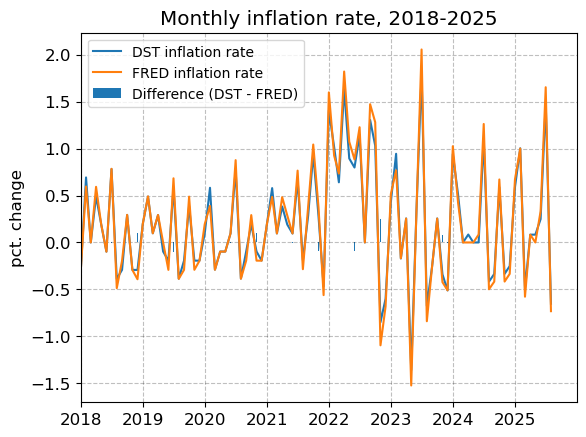

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(merge_inflation.index, merge_inflation['DST_inflation'], label='DST inflation rate')
ax.plot(merge_inflation.index, merge_inflation['FRED_inflation'], label='FRED inflation rate')
ax.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('Monthly inflation rate, 2018-2025')
ax.set_ylabel('pct. change')
ax.legend(loc='upper left',prop={'size': 10})

The two series are very similar, with a mean difference of only 0.0697 percentage points over the period 2000-2025. 

From the plot above, it is evident that the two series track each other closely, with only minor deviations.

### 2.2 <a id="sec2-2"></a>[Across countries](#toc0_)

#### 2.2.1: Compare HICP (All Items) across countries

Data is downloaded and prepared:

In [867]:
series = {
     "CP0000DKM086NEST":"Denmark",
     "CP0000ATM086NEST":"Austria",
     "CP0000EZ19M086NEST":"Euro Area",
     "CP0000USM086NEST":"United States"

}

In [868]:
for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,CP0000DKM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000ATM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000EZ19M086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000USM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


In [869]:
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded CP0000DKM086NEST from FRED and saved it as Denmark        
Downloaded CP0000ATM086NEST from FRED and saved it as Austria        
Downloaded CP0000EZ19M086NEST from FRED and saved it as Euro Area      
Downloaded CP0000USM086NEST from FRED and saved it as United States  


In [870]:
HICP= pd.DataFrame(data)
HICP.head()

,Denmark,Austria,Euro Area,United States
1996-01-01,70.4,71.34,70.40,NaN
1996-02-01,70.8,71.55,70.71,NaN
1996-03-01,71.3,71.77,71.01,NaN
1996-04-01,71.5,71.69,71.14,NaN
1996-05-01,71.7,71.62,71.32,NaN


In [871]:
HICP=HICP.rename_axis('DATE')


HICP for each country is plotted against eachother over the period 2019-2025:

(100.0, 140.0)

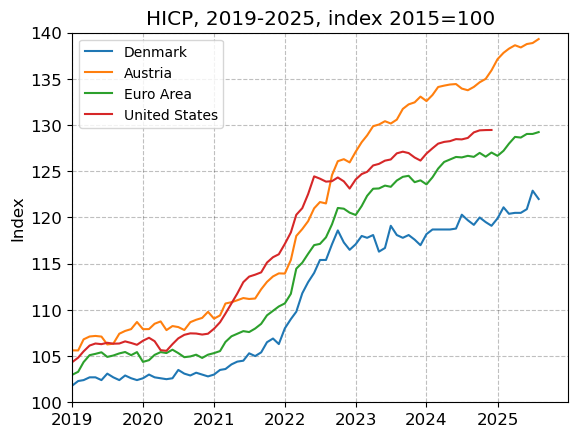

In [887]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for col in HICP.columns:
    ax.plot(HICP.index, HICP[col], label=col)

ax.set_title('HICP, 2019-2025, index 2015=100')
ax.set_ylabel('Index')
ax.legend(loc='upper left',prop={'size': 10})
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2025-12-31'))
ax.set_ylim(100,140)


MANGLER: Compare HICP (All Items) across countries

#### 2.2.2: 12-month HICP

For each column in HICP the 12-month inflation is computed using the pct_change method evaluated at periods=12:

In [888]:
for col in HICP.columns:
    if col in ['Denmark', 'Austria', 'Euro Area', 'United States']:
        HICP[f'{col}_12Month'] = HICP[col].pct_change(periods=12, fill_method=None)*100

The 12-month inflation rate is plotted for each country over the period 2019-2025:

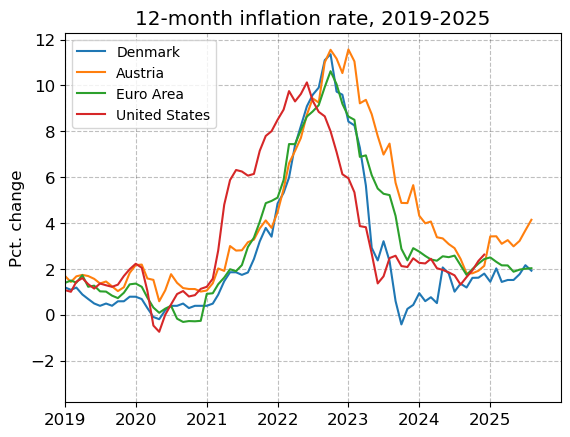

In [891]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for col in HICP.columns:
    if col.endswith('_12Month'):
        label=col.replace('_12Month','')
        ax.plot(HICP.index, HICP[col], label=label)

ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2025-12-31'))
ax.set_title('12-month inflation rate, 2019-2025')
ax.set_ylabel('Pct. change')
ax.legend(loc='upper left',prop={'size': 10})

MANGLER: compare the 12-month HICP inflation rate across countries

#### 2.2.3: min., max., and mean 12-month inflation rate 

In order to group by year, a year variable is created. 

In [894]:
HICP['DATE']=HICP.index
HICP['year']=HICP['DATE'].dt.year

Defining the columns we want to extract: 

In [926]:
cols = [c for c in HICP.columns if c.endswith('_12Month')]

Grouping by year the 12-month inflation mean, minimum and maximum is computed per year and per country:

In [927]:
by_year_country = (
    HICP.groupby('year')[cols]
        .agg(['min','mean','max'])
        .round(2).reset_index()
)

Defining the years of interest in order to filter the dataframa: 

In [ ]:
I = (by_year_country.year >= 2019) & (by_year_country.year <= 2025)
by_year_country=by_year_country.loc[I]

Renaming the columns from Country/Area_12Month to Country/Area:

In [930]:
by_year_country = by_year_country.rename(
    columns=lambda s: s.replace('_12Month', ''), level=0
)

Setting the year as index for a cleaner layout:

In [931]:
by_year_country=by_year_country.set_index('year')

In [932]:
display(by_year_country)

Denmark              Austria              Euro Area               \
         min  mean    max     min  mean    max       min  mean    max   
year                                                                    
2019    0.39  0.73   1.19    1.03  1.49   1.83      0.73  1.20   1.72   
2020   -0.19  0.33   0.79    0.59  1.39   2.19     -0.31  0.26   1.36   
2021    0.39  1.94   3.79    1.06  2.76   4.11      0.91  2.59   4.96   
2022    4.85  8.51  11.36    4.48  8.59  11.55      5.11  8.36  10.62   
2023   -0.42  3.44   8.43    4.87  7.78  11.57      2.37  5.46   8.64   
2024    0.51  1.27   2.06    1.81  2.93   4.32      1.74  2.36   2.75   
2025    1.43  1.72   2.16    2.98  3.40   4.14      1.88  2.12   2.50   

     United States               
               min  mean    max  
year                             
2019          1.00  1.37   1.99  
2020         -0.74  0.77   2.22  
2021          1.22  5.33   8.01  
2022          6.13  8.69  10.13  
2023          1.37  3.03   5.95  
2024          1.32  2.03   2.62  
2025           NaN   NaN    NaN

Mangler: Summarize the cross-country differences in the path of inflation since 2019.